<a href="https://colab.research.google.com/github/Charles-Scott-Green/Crowdfunding-revenue-prediction/blob/master/Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries, Settings, & Functions

In [0]:
# Import libraries
import glob, os 
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set()

In [0]:
import scipy.stats as stats
from scipy.stats.mstats import winsorize

import warnings

In [0]:
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

import umap

from xgboost import XGBRegressor

In [0]:
# Settings
sns.set()

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [0]:
# Functions
# Datetime data processing

def convert_to_datetime(df, column):
    """Searches dataframe for potential datetime data and ensures it is 
    formatted appropriately.  Converts objects to date time format and
    appends datetime columns to list of date time columns (erroneously
    selected columns excluded)."""
   
    try:
        df[column] = pd.to_datetime(df[column], unit = 's')
    
    except Exception:
        next
    
    return df
    
def meta_date(df, column):
    """Searches dataframe columns for column names with including word 'date' and 
    for datetime formats.  """
    
    import re
    date_splits = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 
                   'Is_month_end', 'Is_month_start', 'Is_quarter_end',  
                   'Is_year_end', 'Is_year_start'] 
    
    prefix = re.sub('[Dd]ate$', '', column)
  
    for split in date_splits:
        df[prefix+'_'+split] = getattr(df[column].dt, split.lower())
    
def count_syllables(blurbs):
    """Given a string, calculates and returns the number of syllables of the word."""
    import string
    
    word_list = blurbs.translate(string.punctuation).split()
    vowels = "aeiouy"
    tally = 0
    
    for word in word_list:
        word = word.lower()
        vowels = "aeiouy"
        count = 0

        if word[0] in vowels:
            count += 1

        for i in range(1, len(word)):
            if word[i] in vowels and word[i - 1] not in vowels:
                count += 1

        if word.endswith('e'):
            count -= 1

        if count == 0:
            count += 1
    
        tally += count
    
    return tally

def count_words(blurbs):
    """Returns a count of all words, less punctuation, of a given string."""
    import string

    return len(blurbs.translate(string.punctuation).split())

def count_text_attributes(df, columns):
    """Given columns to convert, returns dataframe with columns replaced with 
    new columns reflecting word and syllable counts."""
    
    new_df = df.copy()
    
    for column in columns:
        new_df[column+'_syllables'] = [count_syllables(x) for x in df[column]]
        new_df[column+'_words'] = [count_words(x) for x in df[column]]
    
    new_df = new_df.drop(columns=columns, axis=1)
    
    return new_df 
        
def model_scorer(y_test, y_predict, model_name='Model', metric=[]):
    """Given prediction (y_predict) and dependent variable (y_test) data,
    function returns calculated MAE, MSE, RMSE, and/or MAPE scores. Inputs:
    y_test - test data from dataset
    y_predict - model predictions of X_test data (should be shame shape as y_test)
    model_name - string input identifying the model; default is 'Model'
    metric - a list input specifying the desired metric or combination of metrics
             to calculate.  Will accept 'mae', 'mse', 'rmse', 'mape'; default
             is empty list that returns all calculations."""
    
    from statsmodels.tools.eval_measures import mse, rmse  
    from sklearn.metrics import mean_absolute_error
    
    error = y_test - y_predict
    
    a = mean_absolute_error(y_test, y_predict)
    b = mse(y_test, y_predict)
    c = rmse(y_test, y_predict)
    d = np.mean(np.abs(error)/(y_test)*100)
    
    metric_dict = {'mae':a, 'mse':b, 'rmse':c, 'mape':d}
    label_dict = {'mae':'Mean Absolute Error', 
                  'mse':'Mean Squared Error', 
                  'rmse':'Root Mean Squared Error', 
                  'mape':'Mean Absolute Percentage Error'}
    
    if len(metric)<1:
        print(f'------- {model_name} Model Eval. -------')
        print(f'Mean Absolute Error: {a}')
        print(f'Mean Squared Error:{b}')
        print(f'Root Mean Squared Error: {c}')
        print(f'Mean Absolute Percentage Error: {d}') 
    else:
        print(f'------- {model_name} Model Eval. -------')
        for m in metric:
            print(f'{label_dict[m]}:  {metric_dict[m]}')

## Load Data


With the large number of features, and with many of the features showing virtually no correlation with the target variable, a naive approach to feature selection will utilized.  

In this case, a Random Forest Model, with n_estimater=10, will be used to evaluate and return feature importances.  

Data will be split into continuous and categorical variables and evaluated separately.  After determining the most predictive features, other feature data will be discarded from each set.  Finally, the continuous and categorical will be combined for modeling.
 


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data_2b.csv'

df = pd.read_csv(path, low_memory=False)

df.head()

,Unnamed: 0,backers_count,is_starrable,spotlight,staff_pick,state,static_usd_rate,usd_pledged,usd_goal,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_year_end,created_at_Is_year_start,deadline_Year,deadline_Month,deadline_Week,deadline_Day,deadline_Dayofweek,deadline_Dayofyear,deadline_Is_month_end,deadline_Is_month_start,deadline_Is_quarter_end,deadline_Is_year_end,deadline_Is_year_start,launched_at_Year,launched_at_Month,launched_at_Week,launched_at_Day,launched_at_Dayofweek,launched_at_Dayofyear,launched_at_Is_month_end,launched_at_Is_month_start,launched_at_Is_quarter_end,launched_at_Is_year_end,launched_at_Is_year_start,created_to_launch_elapsed,created_to_deadline_elapsed,launch_to_deadline_elapsed,blurb_syllables,blurb_words,name_syllables,name_words,pcat_comics,pcat_crafts,pcat_dance,pcat_design,pcat_fashion,pcat_film & video,pcat_food,pcat_games,pcat_journalism,pcat_music,pcat_photography,pcat_publishing,pcat_technology,pcat_theater,subcat_academic,subcat_accessories,subcat_action,subcat_animals,subcat_animation,subcat_anthologies,subcat_apparel,subcat_apps,subcat_architecture,subcat_art,subcat_art books,subcat_audio,subcat_bacon,subcat_blues,subcat_calendars,subcat_camera equipment,subcat_candles,subcat_ceramics,subcat_children's books,subcat_childrenswear,subcat_chiptune,subcat_civic design,subcat_classical music,subcat_comedy,subcat_comic books,subcat_comics,subcat_community gardens,subcat_conceptual art,subcat_cookbooks,subcat_country & folk,subcat_couture,subcat_crafts,subcat_crochet,subcat_dance,subcat_design,subcat_digital art,subcat_diy,subcat_diy electronics,subcat_documentary,subcat_drama,subcat_drinks,subcat_electronic music,subcat_embroidery,subcat_events,subcat_experimental,subcat_fabrication tools,subcat_faith,subcat_family,subcat_fantasy,subcat_farmer's markets,subcat_farms,subcat_fashion,subcat_festivals,subcat_fiction,subcat_film & video,subcat_fine art,subcat_flight,subcat_food,subcat_food trucks,subcat_footwear,subcat_gadgets,subcat_games,subcat_gaming hardware,subcat_glass,subcat_graphic design,subcat_graphic novels,subcat_hardware,subcat_hip-hop,subcat_horror,subcat_illustration,subcat_immersive,subcat_indie rock,subcat_installations,subcat_interactive design,subcat_jazz,subcat_jewelry,subcat_journalism,subcat_kids,subcat_knitting,subcat_latin,subcat_letterpress,subcat_literary journals,subcat_literary spaces,subcat_live games,subcat_makerspaces,subcat_metal,subcat_mixed media,subcat_mobile games,subcat_movie theaters,subcat_music,subcat_music videos,subcat_musical,subcat_narrative film,subcat_nature,subcat_nonfiction,subcat_painting,subcat_people,subcat_performance art,subcat_performances,subcat_periodicals,subcat_pet fashion,subcat_photo,subcat_photobooks,subcat_photography,subcat_places,subcat_playing cards,subcat_plays,subcat_poetry,subcat_pop,subcat_pottery,subcat_print,subcat_printing,subcat_product design,subcat_public art,subcat_publishing,subcat_punk,subcat_puzzles,subcat_quilts,subcat_r&b,subcat_radio & podcasts,subcat_ready-to-wear,subcat_residencies,subcat_restaurants,subcat_robots,subcat_rock,subcat_romance,subcat_science fiction,subcat_sculpture,subcat_shorts,subcat_small batch,subcat_social practice,subcat_software,subcat_sound,subcat_space exploration,subcat_spaces,subcat_stationery,subcat_tabletop games,subcat_taxidermy,subcat_technology,subcat_television,subcat_textiles,subcat_theater,subcat_thrillers,subcat_translations,subcat_typography,subcat_vegan,subcat_video,subcat_video art,subcat_video games,subcat_wearables,subcat_weaving,subcat_web,subcat_webcomics,subcat_webseries,subcat_woodworking,subcat_workshops,subcat_world music,subcat_young adult,subcat_zines,AU,BE,CA,CH,DE,DK,ES,FR,GB,HK,IE,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US,winsorized_pledge
0,0,1.386294,False,False,False,failed,1.000000,4.795791,6.908755,2014,9,36,4,3,247,False,False,

In [0]:
df.drop(columns=['Unnamed: 0', 'state'], axis=1, inplace=True)

In [0]:
df.get_dtype_counts()

float64      8
bool       212
int64       22
dtype: int64

In [0]:
df.select_dtypes(include=['int64']).columns

Index(['created_at_Year', 'created_at_Month', 'created_at_Week',
       'created_at_Day', 'created_at_Dayofweek', 'created_at_Dayofyear',
       'deadline_Year', 'deadline_Month', 'deadline_Week', 'deadline_Day',
       'deadline_Dayofweek', 'deadline_Dayofyear', 'launched_at_Year',
       'launched_at_Month', 'launched_at_Week', 'launched_at_Day',
       'launched_at_Dayofweek', 'launched_at_Dayofyear', 'blurb_syllables',
       'blurb_words', 'name_syllables', 'name_words'],
      dtype='object')

In [0]:
# convert applicable 'int64' dtypes to bool and category types
count_col = []

for column in df.columns:
    if df[column].dtype.name == 'int64':
        if 'cat' in column or len(column) == 2:
            df[column] = df[column].astype(bool)
        elif 'at' in column or 'deadline' in column:
            if 'elapsed' not in column:
                df[column] = df[column].astype('category')

df.get_dtype_counts()

category     18
bool        212
float64       8
int64         4
dtype: int64

In [0]:
# Prepare features and target
X = df.drop(columns=['usd_pledged', 'winsorized_pledge'], axis=1)
X_categorical = X.select_dtypes(exclude=['int64', 'float64'])
X_continuous = X.select_dtypes(include=['int64', 'float64'])
y = df['winsorized_pledge']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_categorical, y, 
                                                                    test_size=0.20,
                                                                    random_state=42)

X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_continuous, y, 
                                                                    test_size=0.20,
                                                                    random_state=42)

In [0]:
# 
model_cat = RandomForestRegressor(n_estimators=10)
model_cat.fit(X_train_cat, y_train_cat)

print(model_cat.score(X_train_cat, y_train_cat))
print(model_cat.score(X_test_cat, y_test_cat))

0.9235052478969371
0.5707625160985695


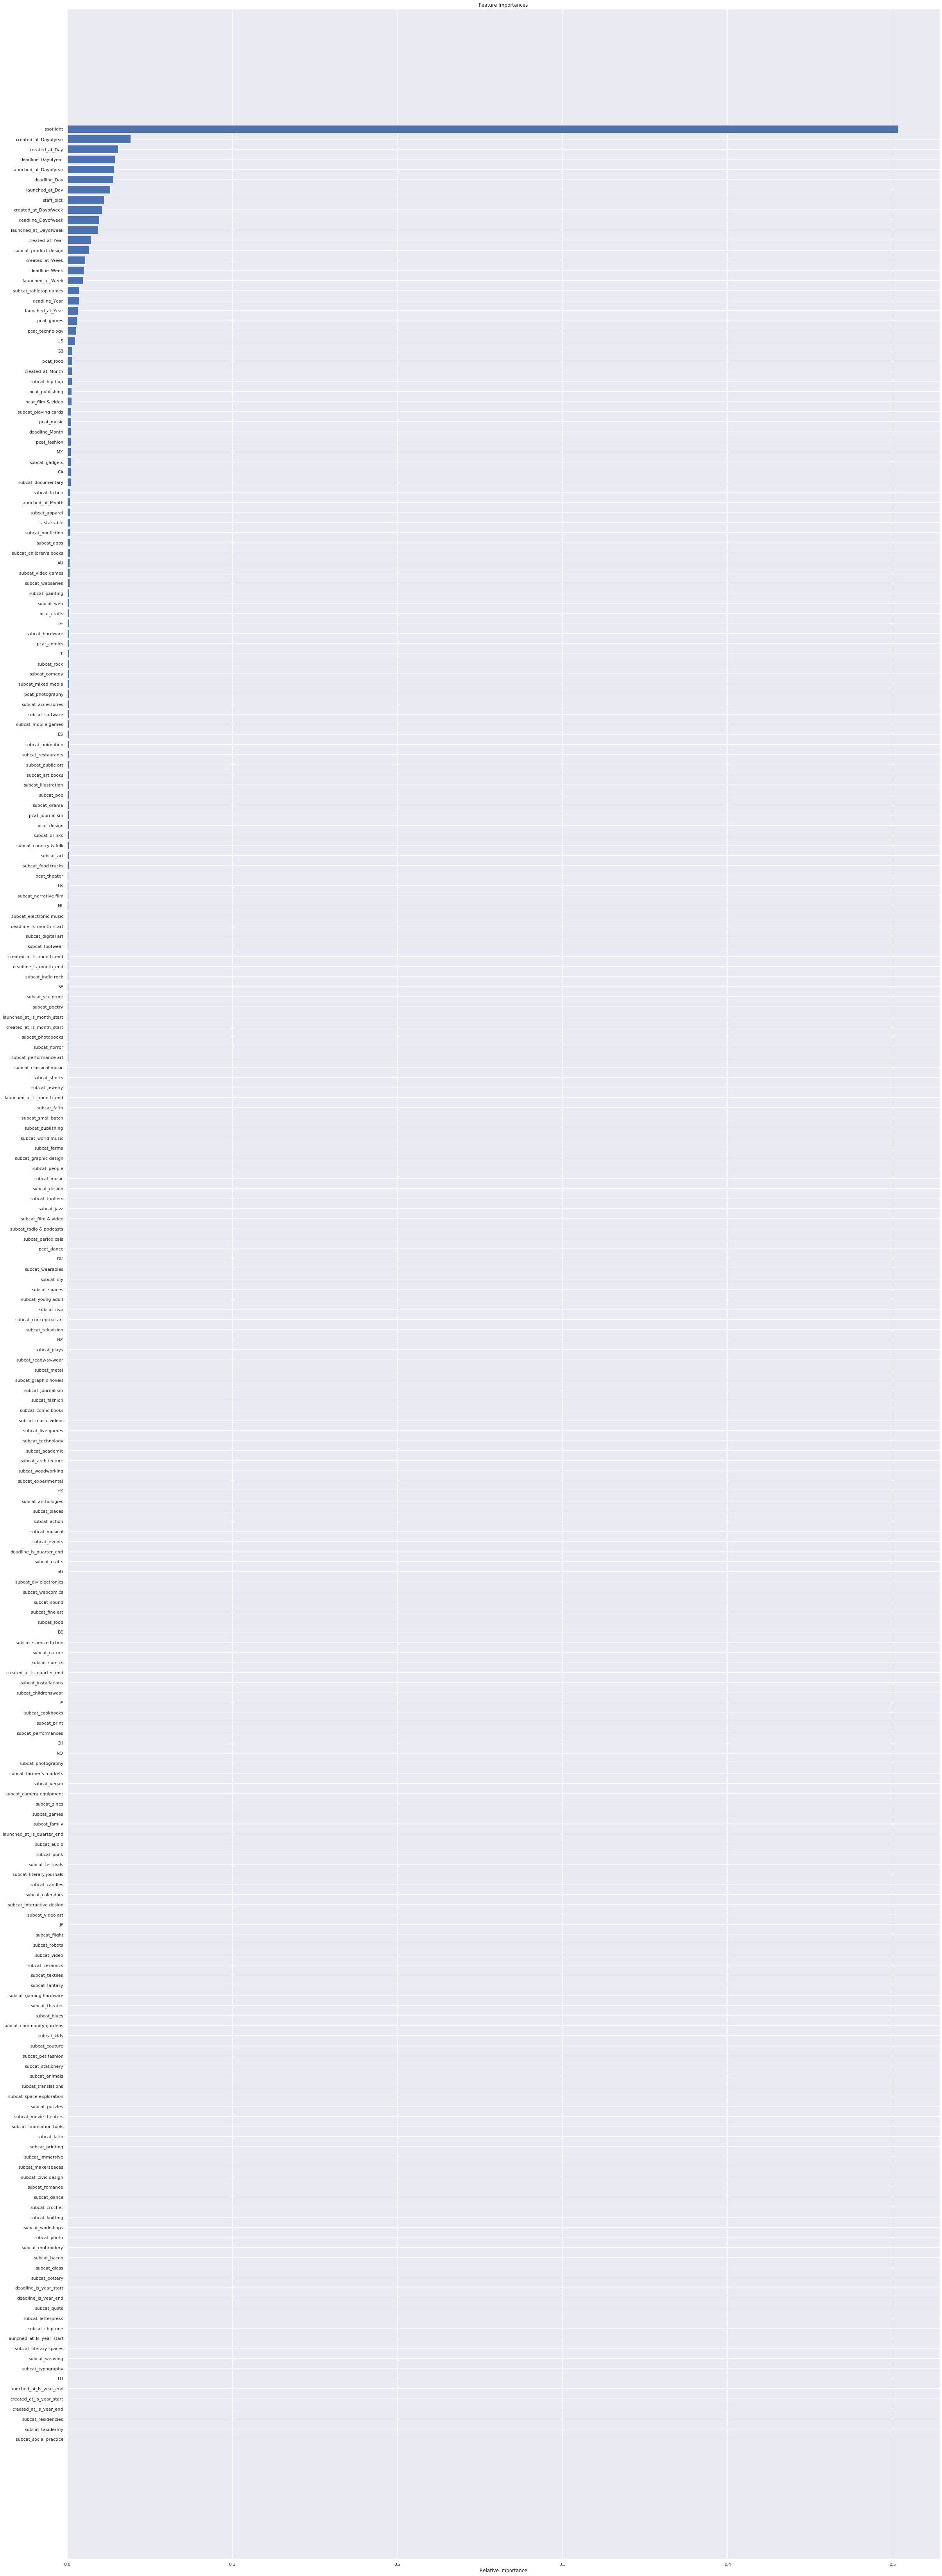

In [0]:
# plot categorical feature importances
features = X_categorical.columns
importances = model_cat.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(40, 120))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
# organize categorical features by importance
cat_fi = []

for i in indices:
    cat_fi.append(X_categorical.columns[i])

# Find the index of cutoff
print(cat_fi.index('subcat_food trucks'))

156


In [0]:
# Trim categorical features
X_categorical = X_categorical[cat_fi[156:]]

In [0]:
# 
model_con = RandomForestRegressor(n_estimators=10)
model_con.fit(X_train_con, y_train_con)

print(model_con.score(X_train_con, y_train_con))
print(model_con.score(X_test_con, y_test_con))

0.9791609624120432
0.8829725887366092


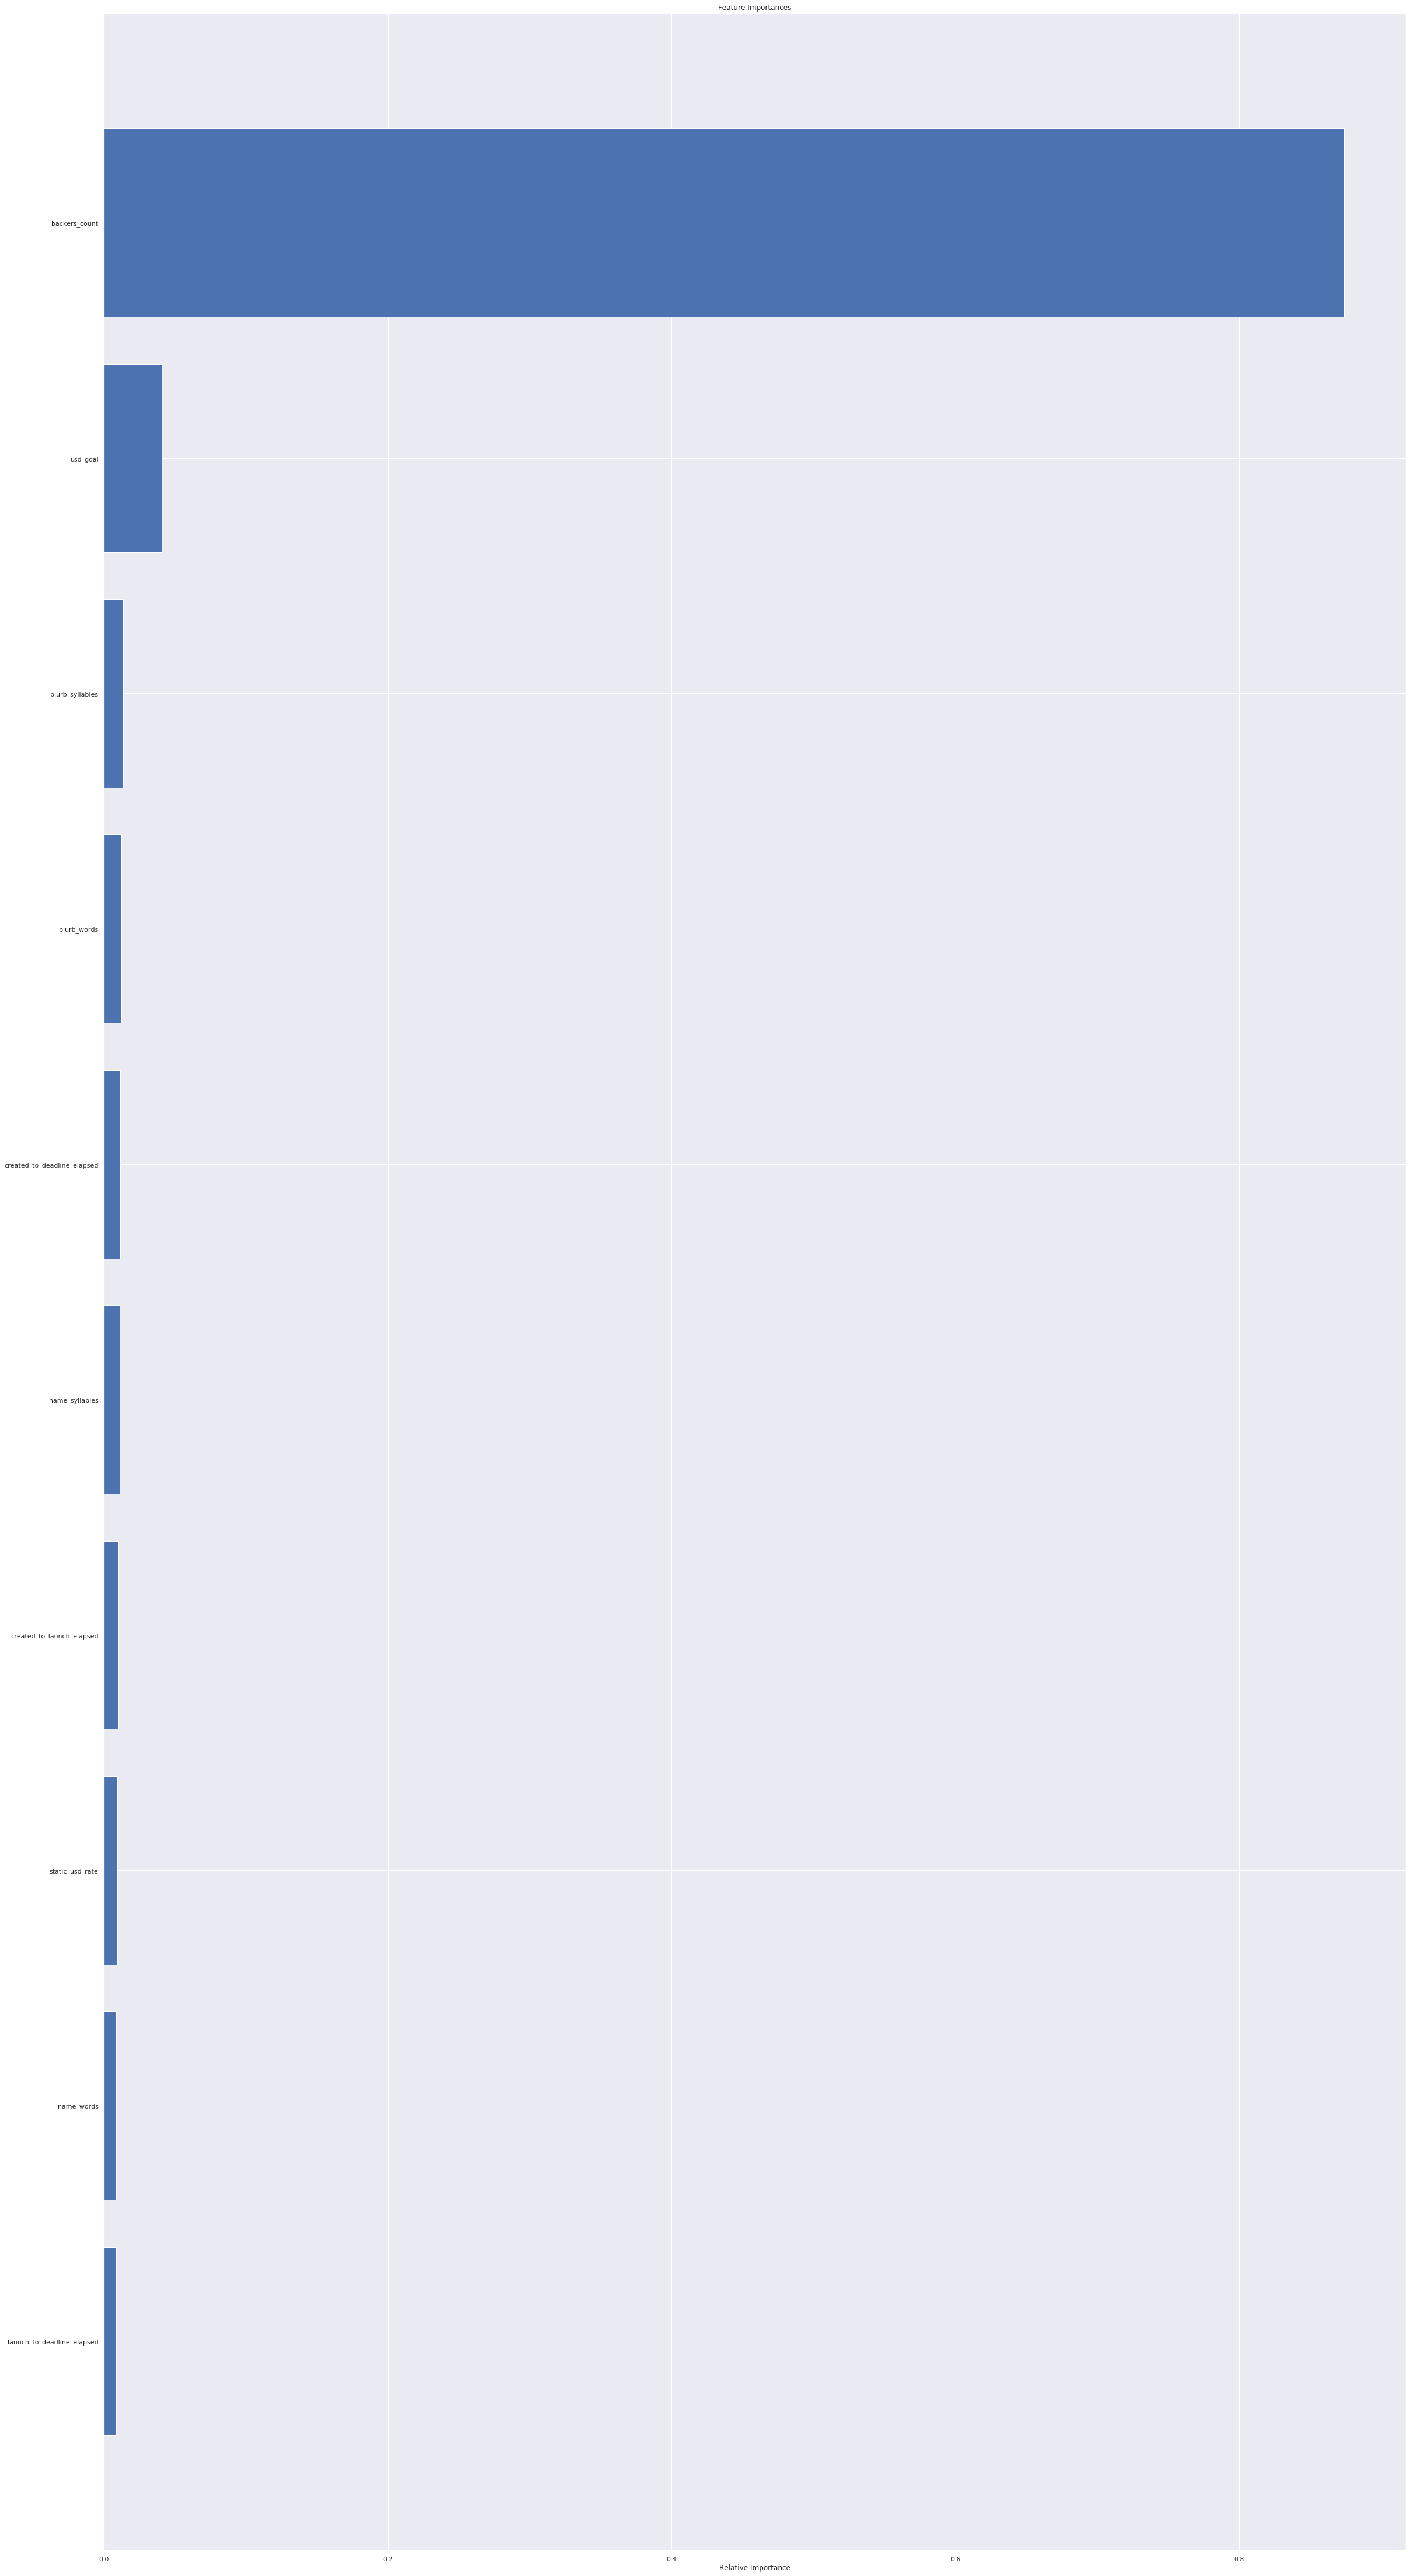

In [0]:
# plot categorical feature importances
features = X_continuous.columns
importances = model_con.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(40, 80))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
# No trimming of continuous variables; concat with trimmed 
# categorical variable data.
X = pd.concat([X_continuous, X_categorical, y], axis=1)

In [0]:
# save second clean version of data
path2 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data_3b.csv'
X.to_csv(path2)